# Support vector machines

**Import Packages to start**

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

**A sample data to demonstrate the technique**

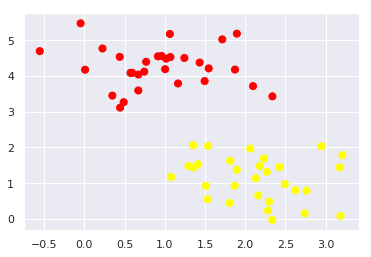

In [0]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=60, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

A linear discriminative classifier can draw a straight line separating the two sets of data, and thereby create a classification model. 
For the above two dimensional data, even we can draw it by hand. 

However, there is more than one possible dividing line that can perfectly discriminate between the two classes!

We can draw them as follows:

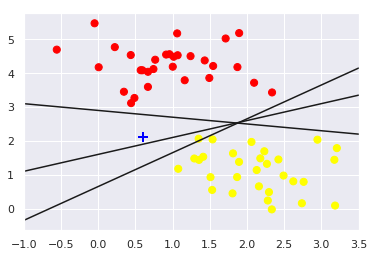

In [0]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], '+', color='blue', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Here we can see three very different separators which, nevertheless, perfectly discriminate between these samples. 

Depending on which line you choose, a new data point (e.g., the one marked by the "+" in this plot) will be assigned a different label

Instead of simply drawing a zero-width line between the classes, we can draw each line a margin of some width, up to the nearest point. For example:

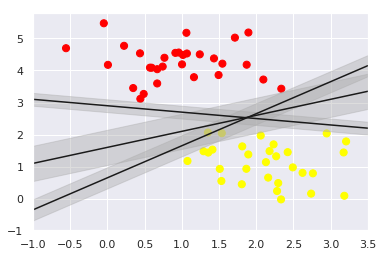

In [0]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

<h2 id="Prepare the SVM model">Prepare the SVM model<a class="anchor-link" href="#Prepare the SVM model">¶</a></h2>

In [0]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

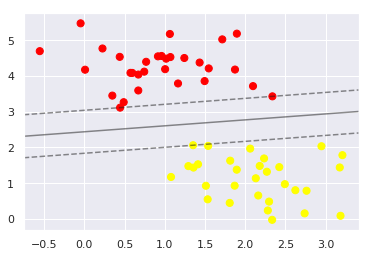

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

In [0]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [1.35139348, 2.06383637]])

For the fit, only the position of the support vectors matter. Any point away from the correct side of the margin do not modify the fit.

This is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

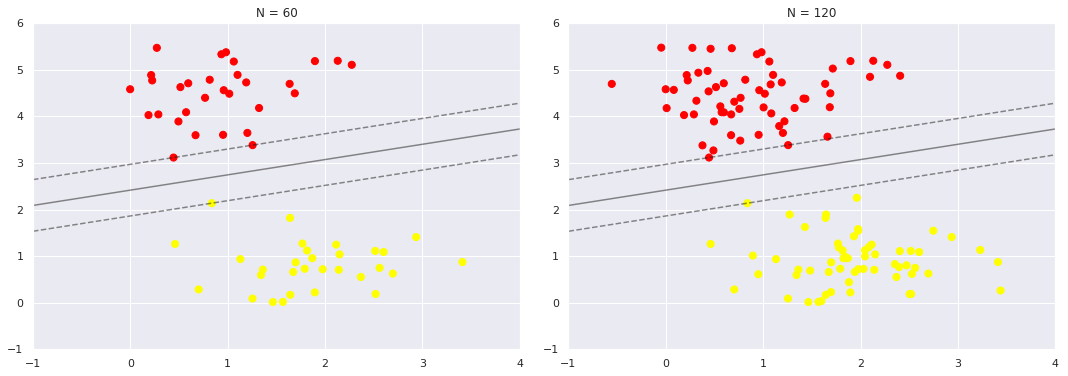

In [0]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))


In the left panel, we see the model and the support vectors for 60 training points. In the right panel, we have doubled the number of training points, but the model has not changed.

Three support vectors from the left panel are the same support vectors from the right panel. 

This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.


Use  interactive widget to view this feature of the SVM model interactively:

In [0]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 20, 30, 50, 100, 200, 1000], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 20, 30, 50, 100, 200, 1000), value=10), Output())…

<h2 id="Tuning the SVM: Softening Margins">Tuning the SVM: Softening Margins<a class="anchor-link" href="#Tuning the SVM: Softening Margins">¶</a></h2>

Above example was very clean dataset, where a perfect decision boundary exists. 

If there is noise in the data or the data is not separable like the data below, we need to soften the margin

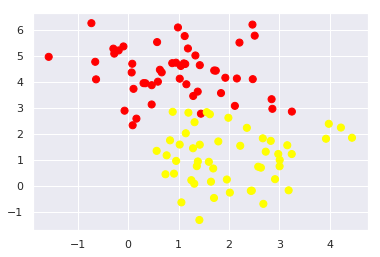

In [0]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

We can crontrol the hardness of the margin by a tuning parameter **(C)**. 

For very large C, the margin is hard, and points cannot lie in it. For smaller C, the margin is softer, and can grow to encompass some points.

The plot shown below gives a visual picture of how a changing C parameter affects the final fit, via the softening of the margin:

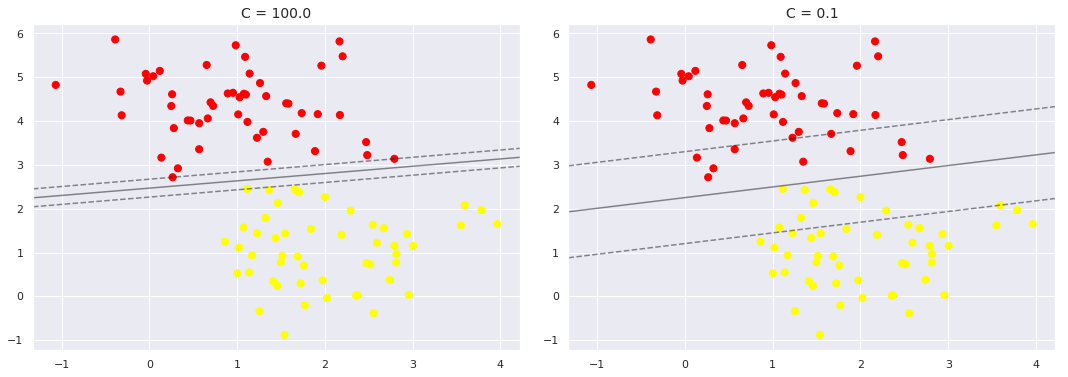

In [0]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

<h2 id="Kernel SVM">Kernel SVM<a class="anchor-link" href="#Kernel SVM">¶</a></h2>

SVM becomes extremely powerful when it is combined with kernels. 

When the data is non separable, we can transorm them into higher dimensionsal spaces to make them linerly separable.

Let's look at some data that is not linearly separable.

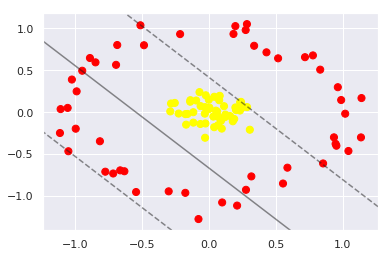

In [0]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

No linear discrimination will ever be able to separate this data. 

However, we can can project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function **(RBF)** centered on the middle clump:

In [0]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot. Please use the sliders to rotate the plot:

In [0]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[0, -90, -45, -15, 15, 40, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(0, -90, -45, -15, 15, 40, 90), value=0), IntSlider…

We can see that with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at, say, r=0.7.

In [0]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

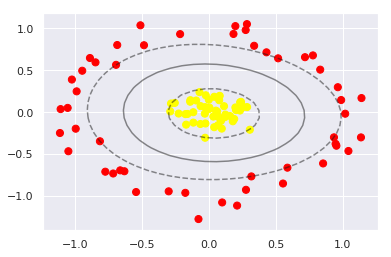

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

# K-Nearest Neighbors Classifier

In [0]:
#generating synthetic data using sklearn library for classification

from sklearn.datasets import make_moons
dataset = make_moons(n_samples=1000, shuffle=True, noise=None, random_state=None)

data_points = dataset[0]
data_labels = dataset[1]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data_points, data_labels, test_size=0.33, random_state=42)

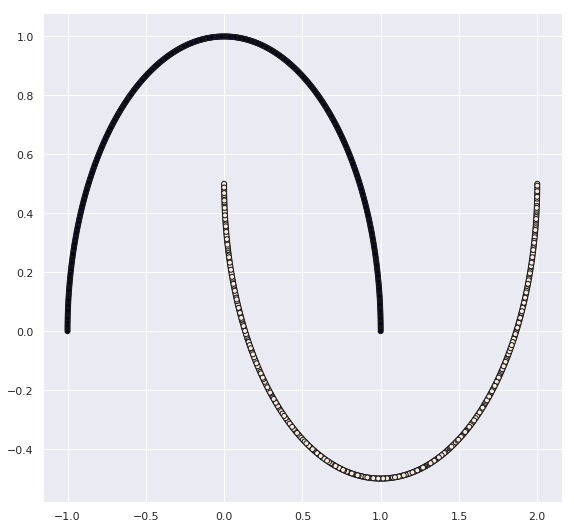

In [0]:
#visualize the data
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)


plt.scatter(data_points[:, 0], data_points[:, 1], marker='o', c=data_labels,
            s=25, edgecolor='k')

In [0]:
#building Knearest Neighbors Classifier on generated data

from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors=5,weights="distance")
classifier.fit(X_train,y_train)
predictions= classifier.predict(X_test)
from sklearn.metrics import accuracy_score

score = accuracy_score(predictions,y_test)

print(score*100)

100.0


Automatically created module for IPython interactive environment
Confusion matrix, without normalization
[[161   0]
 [  0 169]]


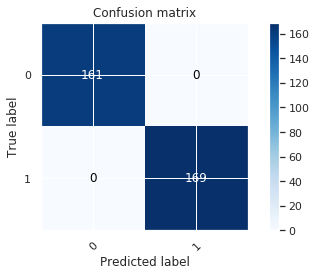

In [0]:
#printing confusion matrix

print(__doc__)

import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

class_names = ['0','1']

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = [classes[i] for i in unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

  
np.set_printoptions(precision=2)

# y_pred = clf.predict(X_test)

#print (class_names, unique_labels(y_pred,y_test), class_names[])

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, predictions, classes=class_names, title='Confusion matrix')

plt.show()

In [0]:
from sklearn.metrics import precision_recall_fscore_support
print(precision_recall_fscore_support(y_test, predictions,average='weighted'))

(1.0, 1.0, 1.0, None)


# K Means

In [0]:
from sklearn.datasets import make_moons, make_blobs


#X,y = make_moons()

X,y = make_blobs(n_features=2,n_samples=1000)

In [0]:
from sklearn.cluster import KMeans

clf = KMeans(n_clusters=13)

clf.fit(X,y)

print (clf)

C = clf.cluster_centers_

print (C.shape)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=13, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)
(13, 2)


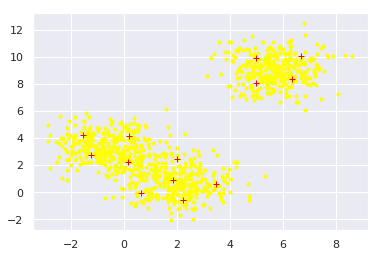

In [0]:
import matplotlib.pyplot as plt

plt.plot(X[:,0],X[:,1],'.',color='yellow')

plt.plot(C[:,0],C[:,1],'+',color='red')